In [1]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterio.plot
from osgeo import gdal
from rasterio import plot, mask, Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.windows import Window
import matplotlib.pyplot as plt
import rasterstats
import rioxarray
from shapely.geometry import box
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
%matplotlib widget
# %matplotlib inline

In [3]:
processed_vrt_path = ["/home/jovyan/nz-landslides/2-processed data/dem/ma_dem_2016.vrt",
                      "/home/jovyan/nz-landslides/2-processed data/dem/ma_dem_2017.vrt",
                     "/home/jovyan/nz-landslides/2-processed data/dem/ma_dem_2018.vrt",
                     "/home/jovyan/nz-landslides/2-processed data/dem/ma_hs.vrt"]

In [4]:
dem16_fn = processed_vrt_path[0]    
dem16_src = rio.open(dem16_fn)
dem16_ma = dem16_src.read(1, masked=True)

In [5]:
dem17_fn = processed_vrt_path[1]    
dem17_src = rio.open(dem17_fn)
dem17_ma = dem17_src.read(1, masked=True)

In [6]:
dem18_fn = processed_vrt_path[2]    
dem18_src = rio.open(dem18_fn)
dem18_ma = dem18_src.read(1, masked=True)

In [7]:
hs_fn = processed_vrt_path[3]    
hs_src = rio.open(hs_fn)
hs_ma = hs_src.read(1, masked=True)

In [8]:
proj_crs = dem16_src.crs
proj_crs

CRS.from_epsg(32759)

In [9]:
inventory_fn = "/home/jovyan/nz-landslides/2-processed data/polygon/clipped_inventory.gpkg"

In [10]:
inventory_gpd = gpd.read_file(inventory_fn)

In [11]:
proj_extent = rio.plot.plotting_extent(dem16_ma, dem16_src.transform)

In [12]:
diff = dem18_ma - dem16_ma
diff

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32)

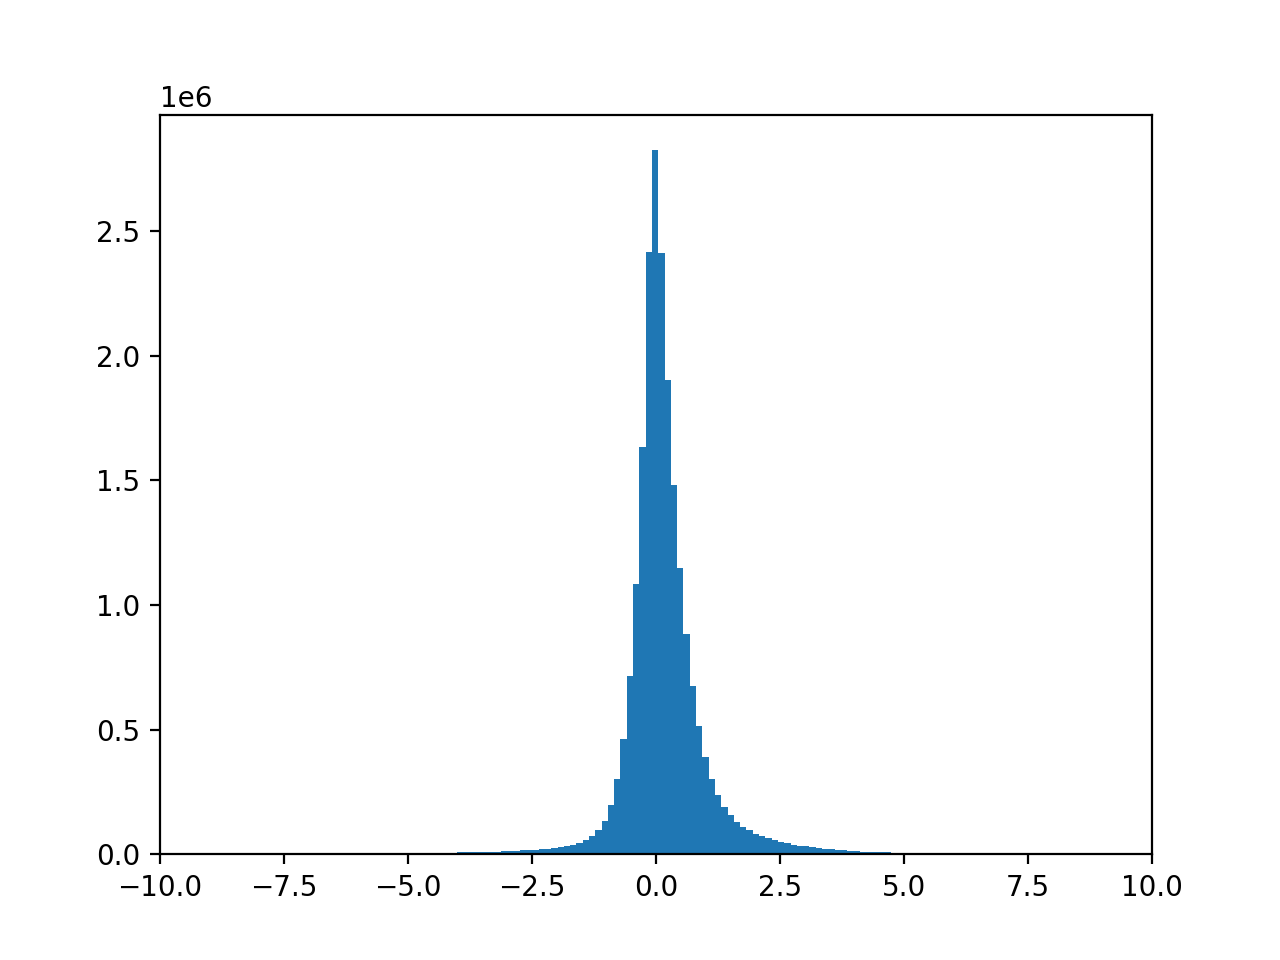

In [13]:
f, ax = plt.subplots(dpi=200)
ax.hist(diff.compressed(), bins=1024);
plt.xlim(-10, 10);

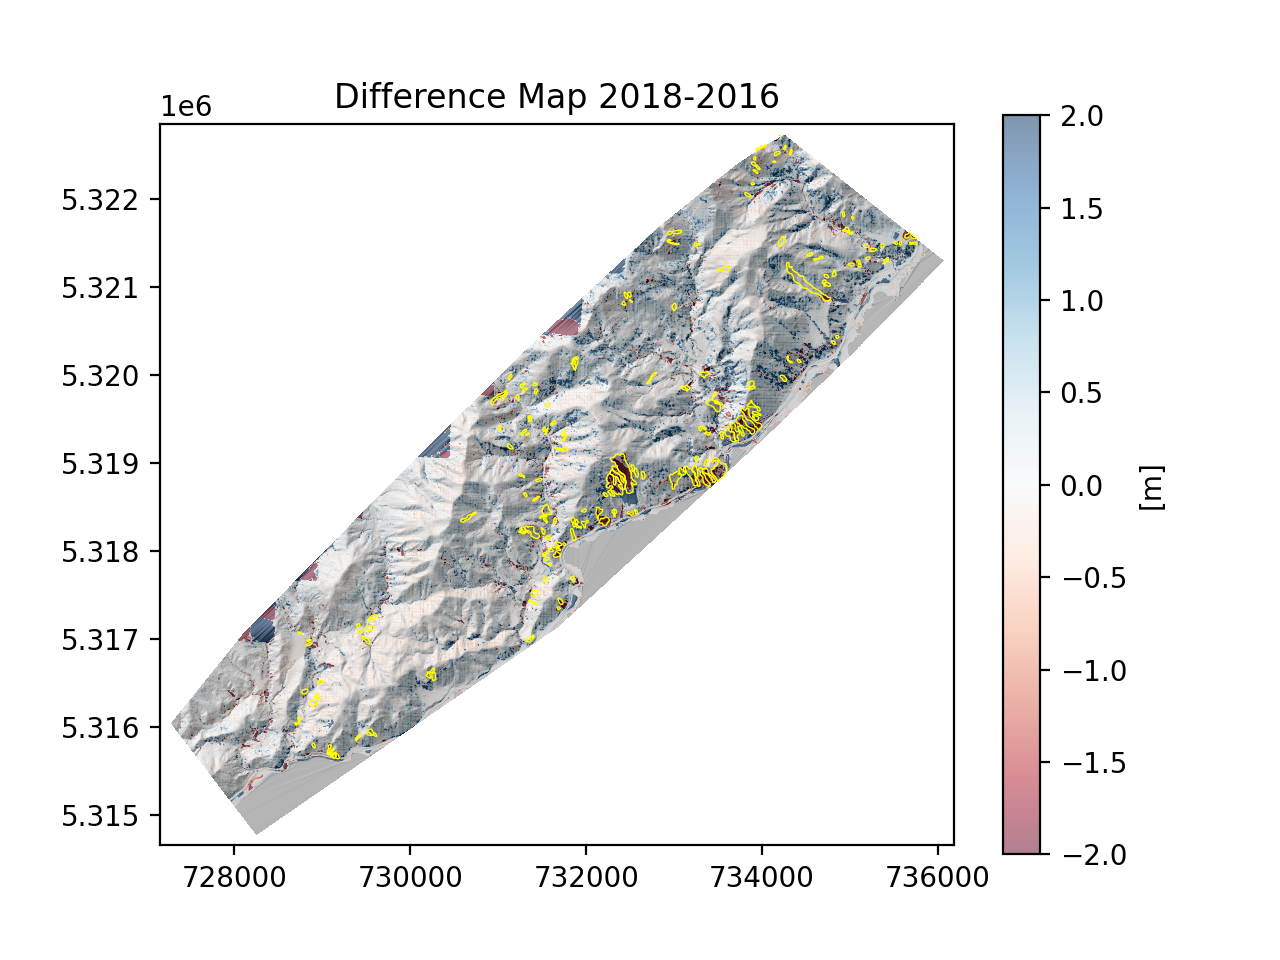

In [14]:
xmin, xmax, ymin, ymax = proj_extent

f, ax = plt.subplots(dpi=200)
ax.imshow(hs_ma, extent=proj_extent, cmap='gray')
im = ax.imshow(diff, extent=proj_extent, vmin=-2, vmax=2, cmap='RdBu', alpha=0.5)
inventory_gpd.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=0.5)
ax.set_title('Difference Map 2018-2016')
f.colorbar(im, ax=ax, label='[m]')
plt.xlim(xmin-100, xmax+100)
plt.ylim(ymin-100, ymax+100)
plt.savefig('diff1816.png', dpi=300)
plt.show()

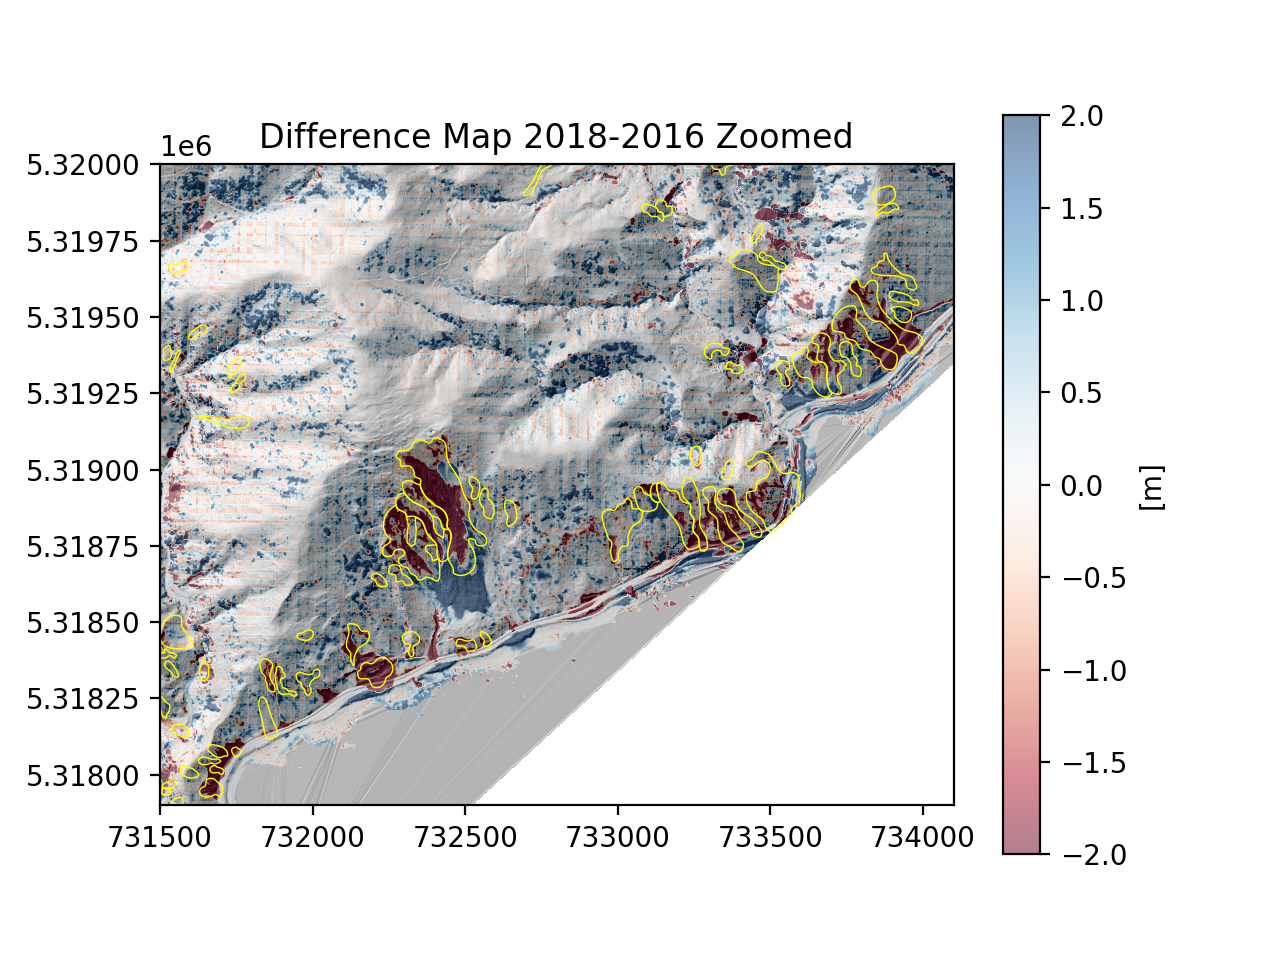

In [15]:
f, ax = plt.subplots(dpi=200)
# f, ax = plt.subplots()
ax.imshow(hs_ma, extent=proj_extent, cmap='gray')
im = ax.imshow(diff, extent=proj_extent, vmin=-2, vmax=2, cmap='RdBu', alpha=0.5)
inventory_gpd.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=0.5)
ax.set_title('Difference Map 2018-2016 Zoomed')
f.colorbar(im, ax=ax, label='[m]')
plt.xlim(731500, 734100)
plt.ylim(5317900, 5320000)
plt.savefig('zoom_diff1816.png', dpi=300)
plt.show()

In [16]:
def create_tif(masked_array, transform, output_path, crs='EPSG:32759', nodata=0.0):
    # Convert the masked array to a filled array with the specified nodata value
    filled_array = np.where(masked_array.mask, nodata, masked_array)

    # Define metadata
    profile = {
        'driver': 'GTiff',
        'height': filled_array.shape[0],
        'width': filled_array.shape[1],
        'count': 1,  # Number of bands
        'dtype': 'float32',  # Data type of the array
        'transform': transform,  # Affine transformation
        'crs': crs,  # CRS (Coordinate Reference System)
        'nodata': nodata  # Nodata value
    }

    # Create the output raster file
    with rasterio.open(output_path, 'w', **profile) as dst:
        # Write the filled array to the raster file
        dst.write(filled_array.astype('float32'), 1)

In [17]:
def create_vrt_from_tif(input_tif, output_vrt):
    # Open the input TIFF file
    tif_ds = gdal.Open(input_tif)

    # Create the VRT dataset
    vrt_ds = gdal.BuildVRT(output_vrt, tif_ds)

    # Close the datasets
    tif_ds = None
    vrt_ds = None

In [18]:
diff_tiff = "/home/jovyan/nz-landslides_local/2-processed data/dem/diff.tif"
diff_vrt = "/home/jovyan/nz-landslides/2-processed data/dem/diff.vrt"

In [19]:
transform = dem16_src.transform
create_tif(diff, transform, diff_tiff, crs='EPSG:32759', nodata=0.0)
create_vrt_from_tif(diff_tiff, diff_vrt)

/srv/conda/envs/notebook/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
